# CPIT 440 lab manual - Lab 10
 
   ## Objective
   
   This lab aims to practice the following:
   1. Ensemble learning
   2. Feature selection


## 1. Ensemble learning

Ensemble methods work best when the predictors are as **independent** from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers. The training set is the moons dataset. The moons dataset has two input features, hence, we can easily visualize the points using scatter plots. The classes are two (0 and 1). If we build the dataset without noise it will be exactly as two crescent moons.

<div>
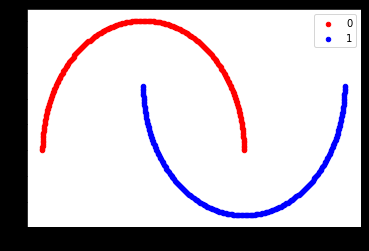
</div>

The following images show how the points of the two crescent moons are scattering as we increase the noise gradually.

When noise = 0.08

<div>
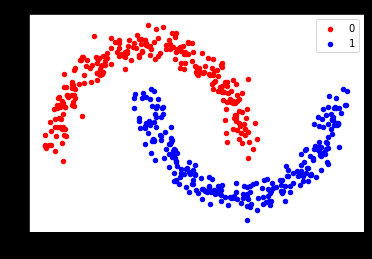
</div>

When noise = 0.2

<div>
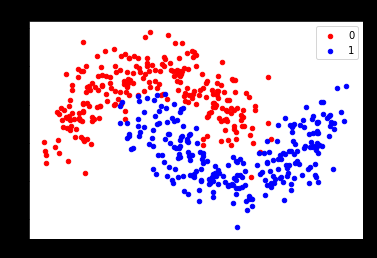
</div>

When noise = 0.32

<div>
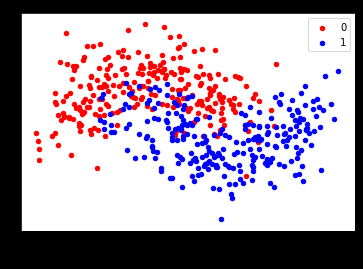
</div>

Now we will create the moon dataset with noise = 0.3 and 500 points and train many classifier on the data.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dr', tree_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dr', DecisionTreeClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let’s look at each classifier’s accuracy on the test set:

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.896
VotingClassifier 0.904


As you see, the voting classifier slightly outperforms all the individual classifiers.

The following plots show the actual classes and the predicted classes by the ensemble classifier.

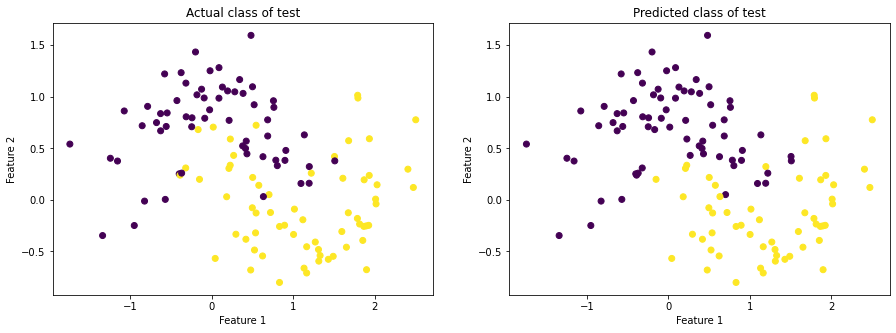

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(15,5))

# Actual classes
axes[0].scatter(X_test[:,0], X_test[:,1], c=y_test )
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title("Actual class of test")

# predicted classes
axes[1].scatter(X_test[:,0], X_test[:,1], c=y_pred)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title("Predicted class of test")

plt.show()

## 2. Feature selection

There are many methods to select the most important features. We will explore the feature selection using `recursive feature elimination (RFE)`. It is suitable for the regression and the classification tasks. As explained in sklearn documentation:  
Given an external estimator that assigns weights to features, the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. 

We will explore it using `digits` dataset. It is an images extracted from  NIST and preprocessed. The resolution of each image is 8 x 8 pixels, hence, the dataset composed of 64 features. It has 1797 samples. More information about the dataset is available in:  
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits


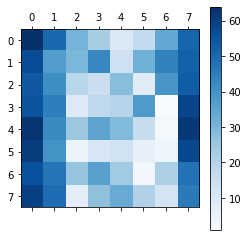

In [29]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear")
rfe1 = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe1.fit(X, y)
ranking = rfe1.ranking_.reshape(8,8)
#ranking = rfe1.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
#plt.title("Ranking of pixels with RFE")
plt.show()

In the parameter `n_features_to_select`, you should determine the number of features that you want the `RFE` to select as best. As we have chosen the value 1, `RFE` will rank all the features and asign First rank for the best feature. You can print the rank of each feature as follwoing:

In [8]:
rfe1.ranking_

array([64, 50, 31, 23, 10, 17, 34, 51, 57, 37, 30, 43, 14, 32, 44, 52, 54,
       41, 19, 15, 28,  8, 39, 53, 55, 45,  9, 18, 20, 38,  1, 59, 63, 42,
       25, 35, 29, 16,  2, 62, 61, 40,  5, 11, 13,  6,  4, 58, 56, 47, 26,
       36, 24,  3, 22, 48, 60, 49,  7, 27, 33, 21, 12, 46])

In [24]:
rfe1.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
import numpy as np
unique, counts = np.unique(rfe1.support_, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 63]
 [ 1  1]]


The feature ranking is the rank of each feature, such that ranking_[ i ] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

In the following code we will do the same task with MNIST dataset. We informed RFE to select the best 200 pixels. At each iteration it will drop the worst 50 features `step=50`.

In [10]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784') 
X, y = mnist["data"], mnist["target"]

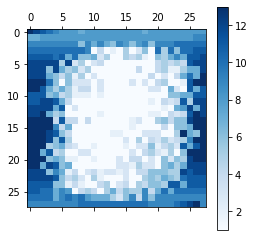

In [11]:
# Create the RFE object and rank each pixel
est1 =  DecisionTreeClassifier(random_state=42)
rfe2 = RFE(estimator=est1, n_features_to_select=200, step=50)
rfe2.fit(X, y)
ranking = rfe2.ranking_.reshape(28, 28)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
#plt.title("Ranking of pixels with RFE")
plt.show()

### How can feature selection help?   
1. When you drop the un-important featutes, this can improve the execution time especially in case of the large datasets while you keep approximately the same performance (accuracy). 
2. Sometimes this will improve the performance because the irrelevant features can cause noise or overfitting.

In the following I will apply the feature selection on the housing prices that we used in the regression example (Lab 7). This dataset after the preprocessing steps has 13 columns. I will select the best 8 features and evaluate how this will affect the performance of the regressor. 

In [12]:
import pandas as pd
url="C:/Users/Asus/Desktop/IT/CPIT440/My Lab/My scripts/Lab 4 and 5 and 6/train_X.csv"
X_train=pd.read_csv(url)
url="C:/Users/Asus/Desktop/IT/CPIT440/My Lab/My scripts/Lab 4 and 5 and 6/train_y.csv"
y_train=pd.read_csv(url)

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100 )
rfe_housing = RFE(estimator=forest_reg, n_features_to_select=8, step=1)
rfe_housing.fit(X_train, y_train.values.ravel())
reduced_housing=rfe_housing.transform(X_train)  #Reduce X to the best selected features.

In [14]:
reduced_housing.shape

(16512, 8)

As shown above RFE selected 8 from 13 features and save it in `reduced_housing`.  
Next we will train a regression model based on the reduced dataset.

In [15]:
forest_reg.fit(reduced_housing, y_train.values.ravel())

RandomForestRegressor()

Now `forest_reg` only knows about the 8 best features and fit the parameters based on this reduced version.  
Following we will evaluate it using cross validation, then we will test the performnce on the test set.

In [16]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


from sklearn.model_selection import cross_validate
forest_output = cross_validate(forest_reg, reduced_housing, y_train.values.ravel(), scoring="neg_mean_squared_error", cv=10,  return_estimator =True)
forest_rmse_scores = np.sqrt(-forest_output["test_score"])
display_scores(forest_rmse_scores)

Scores: [48055.51249642 46334.83164478 49002.36953739 50583.39254709
 48391.76440123 53414.87666527 48636.51209421 50190.17571131
 51782.06736039 49703.42816343]
Mean: 49609.493062152455
Standard deviation: 1908.7151915437098


Based on the score of the cross validation, we only get very small improvement in comparison with the complete dataset. But wait, still we will evaluate on the test set.  
In the following I will print the name of the columns that are selected by RFE and I will reduce the test set to have the same columns.

In [17]:
cols = list(X_train.columns)
temp = pd.Series(rfe_housing.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'median_income', 'INLAND'],
      dtype='object')


In [18]:
type(selected_features_rfe)

pandas.core.indexes.base.Index

In [19]:
temp

longitude              True
latitude               True
housing_median_age     True
total_rooms            True
total_bedrooms         True
population             True
households            False
median_income          True
<1H OCEAN             False
NEAR OCEAN            False
INLAND                 True
NEAR BAY              False
ISLAND                False
dtype: bool

In [20]:
url="C:/Users/Asus/Desktop/IT/CPIT440/My Lab/My scripts/Lab 4 and 5 and 6/test_X.csv"
X_test=pd.read_csv(url)
url="C:/Users/Asus/Desktop/IT/CPIT440/My Lab/My scripts/Lab 4 and 5 and 6/test_y.csv"
y_test=pd.read_csv(url)

In [21]:
X_test = X_test[selected_features_rfe]

In [22]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,median_income,INLAND
0,0.592384,-0.710749,0.027588,1.788385,1.163511,0.684989,2.312998,0.0
1,0.857146,-0.874454,0.822858,0.718423,0.294532,0.223375,0.386117,0.0
2,0.262681,-0.668654,-0.131466,0.811016,0.954177,0.618660,-0.453406,0.0
3,0.712276,-0.673331,1.856709,-0.391288,-0.554973,-0.360140,0.145001,1.0
4,0.947065,-0.734136,0.266169,-0.396432,-0.535500,-0.316219,0.084997,1.0
...,...,...,...,...,...,...,...,...
4123,-0.976205,1.375319,0.345696,1.106097,1.545667,0.891146,-0.998896,1.0
4124,-0.431695,-0.462853,0.107115,-0.167288,-0.053546,-0.015947,-0.997741,0.0
4125,0.542429,-0.682686,0.186642,0.210565,0.340780,0.059346,0.536939,0.0
4126,1.126903,-0.771554,-0.131466,1.328694,0.769184,0.878597,0.438561,1.0


In [23]:
from sklearn.metrics import mean_squared_error
final_predictions = forest_reg.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47076.88464544202

As shown the distance on the test set is reduced from 77751 (in case of all the columns) to 47369 (in case of the best 8 columns). We gain this improvement although that we did not remove the outliers and the capped rows which may increase the improvement. When we compare the distance measured from the cross validation and the test set, they are very close. This means that feature selection helps to avoid the overfitting, hence, we got comparable performance. 